# 动手学深度学习 章节7.5 批量规范化 (batch normalization) 代码实现

In [1]:
import torch
from torch import nn

定义batch normalization层

In [4]:
class BatchNorm(nn.Module):
	def __init__(self, num_features, num_dims, **kwargs) -> None:
		super().__init__(**kwargs)

		if num_dims == 2:
			shape = (1, num_features)
		else:
			shape = (1, num_features, 1, 1)
		self.moving_mean = torch.zeros(shape)
		self.moving_var = torch.zeros(shape)

		# 对每一个特征维度重新赋予可学习的scale和bias参数
		self.gamma = nn.Parameter(torch.ones(shape))
		self.beta = nn.Parameter(torch.zeros(shape))
	

	def forward(self, X):
		if self.moving_mean.device != X.device:
			self.moving_mean = self.moving_mean.to(X.device)
			self.moving_var = self.moving_var.to(X.device)
		
		Y, self.moving_mean, self.moving_var = self.batch_norm(
			X, self.gamma, self.beta, self.moving_mean, self.moving_var,
			eps=1e-5, momentum=0.9
		)

		return Y

	
	@staticmethod
	def batch_norm(X:torch.Tensor, gamma, beta, moving_mean, moving_var, eps, momentum):
		"""
		Applies batch normalization to the input tensor.
		Args:
			X (torch.Tensor): The input tensor of shape
			gamma (torch.Tensor): The learnable scale parameter of shape
			beta (torch.Tensor): The learnable shift parameter of shape
			moving_mean (torch.Tensor): 整体数据集的均值
			moving_var (torch.Tensor): 整体数据集的方差
			eps (float): A small value added to the denominator for numerical stability.
			momentum (float): The momentum for computing the moving average of the mean and variance.
		Returns:
			torch.Tensor: The normalized tensor of the same shape as X.
		"""
		
		if not torch.is_grad_enabled():
			# 使用移动平均的均值和方差对样本进行归一化
			X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
		else:
			assert len(X.shape) in (2, 4)
			# 全连接层, X是2维
			if len(X.shape) == 2:
				mean = X.mean(dim=0)
				var = ((X - mean)**2).mean(dim=0)
			# 卷积层, X是4维
			else:
				mean = X.mean(dim=[0,2,3], keepdim=True)
				var = ((X - mean)**2).mean(dim=[0,2,3], keepdim=True)

			X_hat = (X - mean) / torch.sqrt(var + eps)

			# 使用EMA更新移动平均的均值和方差
			moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
			moving_var = momentum * moving_var + (1.0 - momentum) * var

		# 拉伸和偏移 (重新赋予均值和方差)
		Y = gamma * X_hat + beta

		return Y, moving_mean, moving_var

使用LeNet配合batch normalization

In [5]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

Finally test acc is 0.8847155448717948


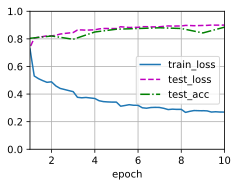

In [6]:
from utils.data.mnist import load_data_fashion_mnist
from utils.train.d2l_train import  train_convolution_network


lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
train_convolution_network(net, train_iter, test_iter, num_epochs, lr)